## Exploring NC NO2 hourly emmisions

**Data Source:** [EPA pregenerated hourly data files](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw)

Including categorical variables

In [1]:
import pandas as pd

### Multiple measurements – All US 2018 data

- Ozone (44201) : 9.5M rows
- SO2 (42401) : 3.9M rows
- CO (42101) : 2.3M rows
- NO2 (42602) : 3.5M rows

Load in one row to see the columns

In [2]:
data_set = "42602"

df_peek = pd.read_csv(
    "./data/AirDataEPA/hourly_"+ data_set + "_2018.csv",
    dtype='str',
    nrows=1
)
df_peek.head()

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Date Local,...,Units of Measure,MDL,Uncertainty,Qualifier,Method Type,Method Code,Method Name,State Name,County Name,Date of Last Change
0,01,073,0023,42602,1,33.553056,-86.815,WGS84,Nitrogen dioxide (NO2),2018-01-01,...,Parts per billion,0.1,NaN,NaN,FEM,200,Teledyne-API Model 200EUP or T200UP - Photolyt...,Alabama,Jefferson,2018-04-11


## Load only NC subset for exploration



In [3]:
dtypes = {
    "State Name": "category",
    "County Name": "category",
    "Site Num": "category"
}

df = pd.read_csv(
    "./data/AirDataEPA/NC_NO2_hourly_2018.csv",
    parse_dates = {"tstamp":["Date Local", "Time Local"]},
    dtype = dtypes
).rename(
    columns = {
        "State Name": "state",
        "County Name": "county",
        "Site Num": "site",
        "Sample Measurement": "measure"
    }
).set_index('tstamp')

In [4]:
df.head()

,site,measure,state,county
tstamp,,,,
2018-01-01 00:00:00,0022,4.4,North Carolina,Forsyth
2018-01-01 01:00:00,0022,5.1,North Carolina,Forsyth
2018-01-01 02:00:00,0022,3.6,North Carolina,Forsyth
2018-01-01 03:00:00,0022,4.1,North Carolina,Forsyth
2018-01-01 04:00:00,0022,4.6,North Carolina,Forsyth


In [5]:
df.shape

(39205, 4)

### Categorical data type saves memory

State column storage in Mb

In [6]:
df['state'].nbytes/1e06

0.039213

#### Temporarily change to string to check the size

In [7]:
df['state'].astype('object').nbytes/1e06

0.31364

## GroupBy County

**Reference different agg formats & Minimally sufficient pandas**

In [8]:
df.groupby('county').agg({'measure':'mean'})

,measure
county,
Forsyth,6.652983
Mecklenburg,8.361926
Wake,6.834003


#### Option to not move groupby categories to index

In [9]:
df.groupby('county', as_index=False).agg({'measure':'mean'}).head()

,county,measure
0,Forsyth,6.652983
1,Mecklenburg,8.361926
2,Wake,6.834003


### Now we see some strange behavior with categorical variables!

Getting NaN for a `mean` operation in Pandas should be a tip-off that something is wrong, because Pandas should ignore any NaN or missing entries and give you the mean of the rest of the values, so with this much data for each county, we should never get NaN for a mean.

In [10]:
df.groupby(['county','site']).agg({'measure':'mean'})

measure
county      site           
Forsyth     0014        NaN
            0021        NaN
            0022   6.652983
            0041        NaN
            0045        NaN
Mecklenburg 0014        NaN
            0021        NaN
            0022        NaN
            0041   6.282450
            0045  10.198556
Wake        0014   4.955026
            0021   8.700441
            0022        NaN
            0041        NaN
            0045        NaN

### Only observed categorical combinations

In [11]:
df.groupby(['county','site'], observed=True).agg({'measure':'mean'})

measure
county      site           
Forsyth     0022   6.652983
Mecklenburg 0041   6.282450
            0045  10.198556
Wake        0014   4.955026
            0021   8.700441

### Takes much longer without the `observed=True`!

The problem gets **much** worse when the data is larger, such as the whole US hourly data! When you include both state, county and site, since without `observed=True` **the groupby() will include all counties and all sites for all states!!** That not only gets us strange results, but takes a huge amount of time to calculate all of those extra combinations! *You get all possible county names for every state, plus all possible site codes for all counties for all states!*

In [12]:
%timeit df.groupby(['county','site']).agg({'measure':'mean'})

8.99 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit df.groupby(['county','site'], observed=True).agg({'measure':'mean'})

5.33 ms ± 50.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Worth it?

This brings up the point whether it's worth it for storage size to have to remember to put `observed=True` in every groupby that includes a categorical variable...

### Multi-index for multiple grouping columns

In [14]:
county_site_df = df.groupby(['county','site'], observed=True).agg({'measure':'mean'})
county_site_df

measure
county      site           
Forsyth     0022   6.652983
Mecklenburg 0041   6.282450
            0045  10.198556
Wake        0014   4.955026
            0021   8.700441

### Use tuples for multi-index access

In [15]:
county_site_df.loc[('Wake','0021'),:]

measure    8.700441
Name: (Wake, 0021), dtype: float64

### Other statistics

MultiIndex is a pain, but that's what you get both in rows and columns when you either do multiple groupby levels or multiple aggregation functions 

In [16]:
df.groupby(['county']).agg({'measure':['min','mean','max']})

measure                
                min      mean   max
county                             
Forsyth         0.4  6.652983  41.0
Mecklenburg     0.3  8.361926  39.6
Wake            0.1  6.834003  38.2

### Sort results

In [17]:
df.groupby(['county']).agg(
    {'measure':['mean','max']}
).sort_values(
    [('measure','mean')],
    ascending=False
)

measure      
                 mean   max
county                     
Mecklenburg  8.361926  39.6
Wake         6.834003  38.2
Forsyth      6.652983  41.0

---

## Pivot table to explore the data

Count of records over the 12 months

[Datetime index attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) – gives you things like month, day, week, etc

## NOTE: Add general pivot_table function interface

In [18]:
df.pivot_table(
    index=['state','county','site'],
    columns=df.index.month,
    values='measure',
    aggfunc='count',
    observed=True
)

tstamp                              1      2      3      4      5      6   \
state          county      site                                             
North Carolina Forsyth     0022  704.0  631.0  701.0  686.0  697.0  676.0   
               Mecklenburg 0041  714.0  644.0  697.0  687.0  705.0  677.0   
                           0045  706.0  635.0  712.0  683.0  703.0  690.0   
               Wake        0014  705.0  509.0  699.0  678.0  692.0  681.0   
                           0021  696.0  634.0  696.0  677.0  698.0  681.0   

tstamp                              7      8      9      10     11     12  
state          county      site                                            
North Carolina Forsyth     0022  706.0  691.0  682.0  702.0  669.0  703.0  
               Mecklenburg 0041  714.0  704.0  525.0  560.0  467.0    NaN  
                           0045  667.0  713.0  530.0  690.0  614.0  689.0  
               Wake        0014  692.0  673.0  537.0  636.0  683.0  704.0  
                           0021  701.0  690.0  537.0  652.0  683.0  597.0

---

## Output styling

Like Excel "Conditional Formatting"

https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

**Note: Color scale is by default column-wise. You can change the axis to 1 for row-wise scaling, but there doesn't seem to be an option for whole table colormap.**


#### Number precision

In [19]:
df.pivot_table(
    index=['state','county','site'],
    columns=df.index.month,
    values='measure',
    aggfunc='count',
    observed=True
).style.set_precision(0)

#### Background gradient (heatmap)

In [20]:
df.pivot_table(
    index=['county','site'],
    columns=df.index.month,
    values='measure',
    aggfunc='mean',
    observed=True
).style.set_precision(1).background_gradient(axis=1).highlight_null('lightgray')

### Bar styling

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.io.formats.style.Styler.bar.html

Higher median in the winter

**Make sure bars go to zero. That's not the default!**

In [21]:
df.pivot_table(
    columns=['county','site'],
    index=df.index.month,
    values='measure',
    aggfunc='median',
    observed=True
).style.set_precision(2).bar(vmin=0, color='#988675', width=90)

### Plots like Excel

**Need the transpose of what we saw above for plotting**

- X axis needs to be on the row index
- Variance goes up in the winter, too

In [22]:
df.pivot_table(
    columns=['county','site'],
    index=df.index.month,
    values='measure',
    aggfunc='var',
    observed=True
)

county    Forsyth Mecklenburg                  Wake           
site         0022        0041       0045       0014       0021
tstamp                                                        
1       77.882226  104.324401  82.647835  82.782695  62.794499
2       34.326836   27.074450  42.037784  27.439889  33.487514
3       24.015538   39.364915  61.835836  27.365762  50.569321
4       14.247983   20.037505  53.408944  20.386915  34.618330
5       12.675053   12.464952  20.769816   9.398296  22.310206
6       11.744187    8.873713  22.072099   6.550815  16.825150
7       14.154879   16.264243  19.768116   6.456586  18.095116
8       14.729542   12.507745  21.548489   8.223004  15.995332
9       13.587151   11.710769  21.745331   7.534293  16.163824
10      22.687209   31.067277  31.478852  37.417039  23.393397
11      34.508910   29.323378  40.682537  27.563008  30.262207
12      71.234665         NaN  52.859365  46.427837  32.685162

### Pandas line plot

- General plot: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
- Line plot: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.line.html

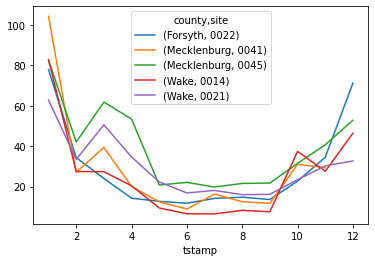

In [23]:
df.pivot_table(
    columns=['county','site'],
    index=df.index.month,
    values='measure',
    aggfunc='var',
    observed=True
).plot()

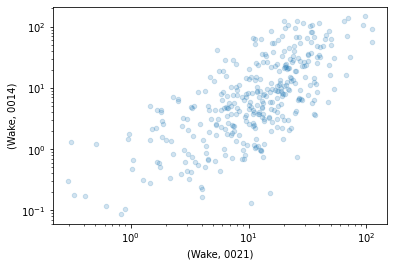

In [24]:
df.pivot_table(
    columns=['county','site'],
    index=df.index.dayofyear,
    values='measure',
    aggfunc='var',
    observed=True
).plot(x=('Wake','0021'),y=('Wake','0014'),kind='scatter',alpha=0.2,logx=True,logy=True)

In [25]:
df.pivot_table(
    index=['county','site'],
    columns=df.index.hour,
    values='measure',
    aggfunc='mean',
    observed=True
).style.set_precision(1).background_gradient(axis=1)

### Plotting needs the transpose

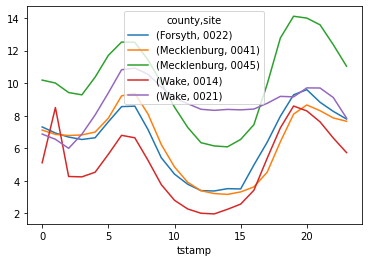

In [26]:
df.pivot_table(
    columns=['county','site'],
    index=df.index.hour,
    values='measure',
    aggfunc='mean',
    observed=True
).plot()

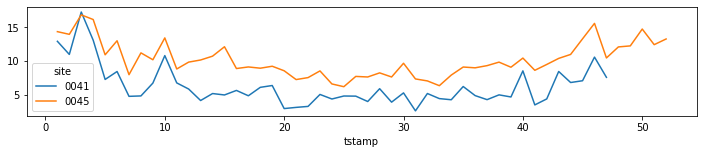

In [27]:
df.pivot_table(
    columns=['county','site'],
    index=df.index.week,
    values='measure',
    aggfunc='mean',
    observed=True
).plot(y=('Mecklenburg'),figsize=(12,2))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa48819d160>,
      dtype=object)

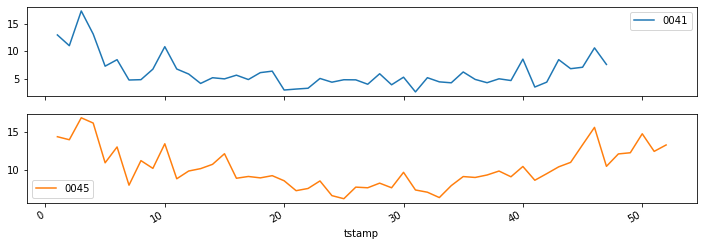

In [28]:
df.pivot_table(
    columns=['county','site'],
    index=df.index.week,
    values='measure',
    aggfunc='mean',
    observed=True
).plot(y=('Mecklenburg'),figsize=(12,4),subplots=True)

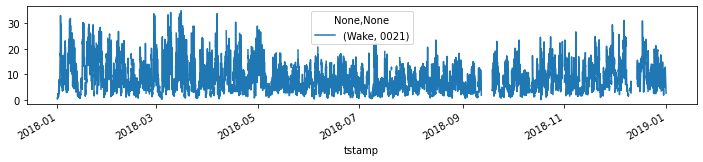

In [29]:
df.pivot_table(
    columns=['county','site'],
    index=df.index,
    values='measure',
    observed=True
).plot(y=('Wake','0021'),figsize=(12,2))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa48041c2b0>,
      dtype=object)

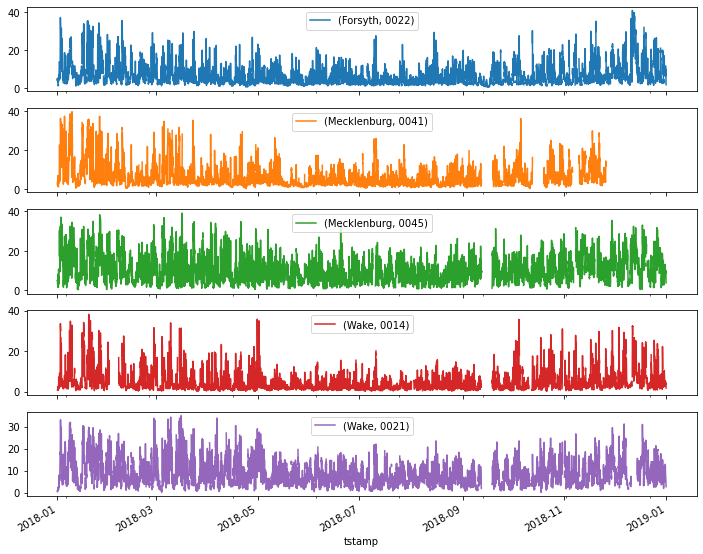

In [30]:
df.pivot_table(
    columns=['county','site'],
    index=df.index,
    values='measure',
    observed=True
).plot(subplots=True,figsize=(12,10))

---

## Altair, Seaborn, and Plotly for plotting

I like Altair, Seaborn, and Plotly for plotting because they want tidy data

- No need to create a pivot table – work directly with groupby()
- Capabilities for creating faceted plots
- Seaborn is better for built-in complicated statistical plots
- Altair has a more consistent interface for all types of plots, and it has built-in aggregation, including time-series, but for large data it works out better to filter and group first rather than letting Altair do the work
- Plotly has nice interaction built in, but Jupyter extension requires setup

**Note: You almost always have to run .reset_index() on the grouped, agregated DataFrame before you can plot with these modules.**

### Daily mean data

In [31]:
grp = df.groupby(['site',df.index.dayofyear]).agg({'measure':'mean'})
grp.head()

measure
site tstamp           
0014 1        2.665217
     2       11.204348
     3       12.730435
     4        2.660870
     5        5.726087

In [32]:
import seaborn as sns

### Faceted line plot with Seaborn

https://seaborn.pydata.org/examples/faceted_lineplot.html

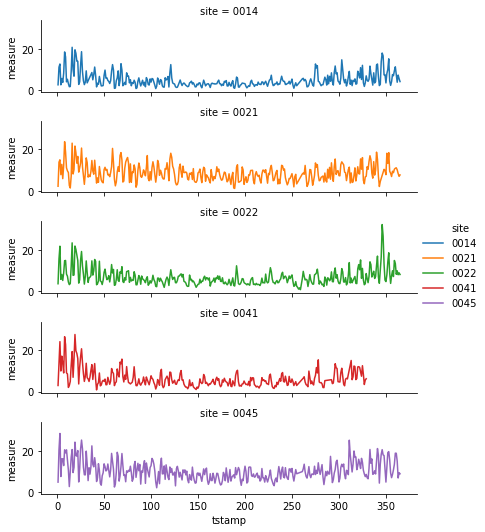

In [33]:
sns.relplot(
    data=grp.reset_index(), 
    x='tstamp', 
    y='measure', 
    hue='site',
    row='site',
    kind='line',
    aspect=4.0,
    height=1.5
)

### Full hourly detail data plot

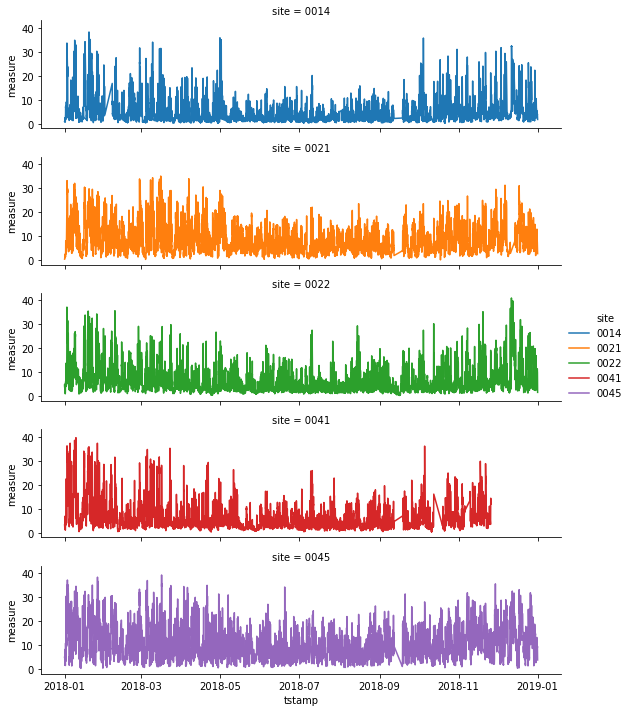

In [34]:
sns.relplot(
    data=df.reset_index(), 
    x='tstamp', 
    y='measure', 
    hue='site',
    row='site',
    kind='line',
    aspect=4.0,
    height=2.0
)

---

### Altair for visualization

- Make sure you use `observed=True` or you'll get all categorical combinations
- `as_index=False` for some reason drops the date month column, so have to use `.reset_index()`

In [35]:
import altair as alt
import seaborn as sns

In [36]:
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

### Daily variations

[Altair time unit transforms](https://altair-viz.github.io/user_guide/transform/timeunit.html)

In [37]:
alt.Chart(df.reset_index()).mark_line().encode(
    x='hours(tstamp):T',
    y='mean(measure):Q',
    color='site:N'
)

alt.Chart(...)

### Color by County-Site combination

In these NC counties, the Site values don't happen to overlap, but they do across the US, so someitmes it's handy to have a column that contains the combination of county and site. **We can't concatenate categorical data types, so need to convert to string first.**

In [38]:
df['county_site'] = df['county'].astype('str') + " " + df['site'].astype('str')

In [39]:
alt.Chart(df.reset_index()).mark_line().encode(
    x='hours(tstamp):T',
    y='mean(measure):Q',
    color='county_site:N'
)

alt.Chart(...)

In [40]:
alt.Chart(df.reset_index()).mark_line().encode(
    x='hours(tstamp):T',
    y='mean(measure):Q',
    color='day(tstamp):N',
    column='county_site:N'
).properties(width=150, height=150)

alt.Chart(...)

In [41]:
meck_0045 = df.loc[df['county_site']=='Wake 0021',:]

alt.Chart(meck_0045.reset_index()).mark_line(opacity=0.2).encode(
    x='hours(tstamp):T',
    y='mean(measure):Q',
    detail='yearmonthdate(tstamp):N'
)

alt.Chart(...)

In [42]:
meck_0045 = df.loc[df['county_site']=='Wake 0021',:]

alt.Chart(meck_0045.reset_index()).mark_line().encode(
    x='hours(tstamp):T',
    y='mean(measure):Q',
    color='day(tstamp):N'
)

alt.Chart(...)

### Look at the whole time-series

In [43]:
alt.Chart(df.reset_index()).mark_line().encode(
    x='tstamp:T',
    y='measure:Q',
    color='county_site:N'
).properties(
    height=80
).facet(
    row='county_site:N',
    spacing={"row":-1}
).interactive(bind_y=False)

alt.FacetChart(...)

In [44]:
alt.Chart(df.reset_index()).mark_line().encode(
    x='yearmonthdate(tstamp):T',
    y='median(measure):Q',
    color='county_site:N'
).properties(
    height=80
).facet(
    row='county_site:N',
    spacing={"row":-1}
).interactive(bind_y=False)

alt.FacetChart(...)

---

## Daily min max

To see if there are any patterns in time of day, lets get compensate for the variation in daily min and max values and normalize.

We can use `.groupby()` to calculate the daily min and max values, but we'll need to do arithmetic on the hourly measurements with these values, so we need them copied to all rows (not just one number per day like we would get with a typical groupby and aggregation procedure.

Instead of `.agg()` or `.aggregate()`, we use `.transform()` to run a function within each of the groups but keep the number of rows the same as the original DataFrame.

In [45]:
df.groupby(
    ['county','site',df.index.date],
    observed=True
).agg({'measure':'min'}).head()

measure
county  site                    
Forsyth 0022 2018-01-01      1.1
             2018-01-02      4.6
             2018-01-03      8.8
             2018-01-04      2.7
             2018-01-05      2.2

#### Have to select a column for `.transform()`

With `.transform()` we don't have the same dictionary-style selection of which columns we're going to apply which aggregate functions to – it takes just a single funciton – so we need to select a certain column to transform with the standard "name of a column in square brackets" syntax.

In [46]:
df.groupby(
    ['county','site',df.index.date],
    observed=True
)['measure'].transform('min').head(10)

tstamp
2018-01-01 00:00:00    1.1
2018-01-01 01:00:00    1.1
2018-01-01 02:00:00    1.1
2018-01-01 03:00:00    1.1
2018-01-01 04:00:00    1.1
2018-01-01 05:00:00    1.1
2018-01-01 06:00:00    1.1
2018-01-01 07:00:00    1.1
2018-01-01 08:00:00    1.1
2018-01-01 09:00:00    1.1
Name: measure, dtype: float64

### Record the daily max and mix values

We'll create two new columns for the daily max and min values, so we can use them as a reference to normalize the hourly values

In [47]:
df['daily_min'] = df.groupby(['county','site',df.index.date],observed=True)['measure'].transform('min')
df['daily_max'] = df.groupby(['county','site',df.index.date],observed=True)['measure'].transform('max')
df.head(10)

,site,measure,state,county,county_site,daily_min,daily_max
tstamp,,,,,,,
2018-01-01 00:00:00,0022,4.4,North Carolina,Forsyth,Forsyth 0022,1.1,6.5
2018-01-01 01:00:00,0022,5.1,North Carolina,Forsyth,Forsyth 0022,1.1,6.5
2018-01-01 02:00:00,0022,3.6,North Carolina,Forsyth,Forsyth 0022,1.1,6.5
2018-01-01 03:00:00,0022,4.1,North Carolina,Forsyth,Forsyth 0022,1.1,6.5
2018-01-01 04:00:00,0022,4.6,North Carolina,Forsyth,Forsyth 0022,1.1,6.5
2018-01-01 05:00:00,0022,3.2,North Carolina,Forsyth,Forsyth 0022,1.1,6.5
2018-01-01 06:00:00,0022,3.1,North Carolina,Forsyth,Forsyth 0022,1.1,6.5
2018-01-01 07:00:00,0022,4.1,North Carolina,Forsyth,Forsyth 0022,1.1,6.5
2018-01-01 08:00:00,0022,4.0,North Carolina,Forsyth,Forsyth 0022,1.1,6.5


### Perform the normalization on all rows

We'll calculate the difference above the daily min, divided by the maximum range of values

In [48]:
df['daily_norm'] = (df['measure']-df['daily_min'])/(df['daily_max']-df['daily_min'])

#### See the curves after normalization

In [49]:
alt.Chart(df.reset_index()).mark_line().encode(
    x='tstamp:T',
    y='daily_norm:Q'
).properties(
    height=80
).facet(
    row='site:N',
    spacing={"row":-1}
).interactive(bind_y=False)

alt.FacetChart(...)

In [50]:
base = alt.Chart(df.reset_index()).mark_line().encode(
    x='hours(tstamp):T',
    y='mean(measure):Q',
    color='county_site:N'
).properties(width=300)
norm = alt.Chart(df.reset_index()).mark_line().encode(
    x='hours(tstamp):T',
    y='mean(daily_norm):Q',
    color='county_site:N'
).properties(width=300)
base | norm

alt.HConcatChart(...)

In [51]:
alt.Chart(df.reset_index()).mark_line().encode(
    x='hours(tstamp):T',
    y='mean(daily_norm):Q',
    color='day(tstamp):N',
    column='county_site:N'
).properties(width=150, height=150)

alt.Chart(...)

### Mean by hour of day

In [52]:
alt.Chart(df.reset_index()).mark_line(clip=True).encode(
    x='hours(tstamp):T',
    y=alt.Y('mean(daily_norm):Q', scale=alt.Scale(domain=[0,1])),
    color='county_site:N',
    detail='county_site:N',
    tooltip='site:N'
).properties(
    width=90,
    height=90
).facet(
    facet='yearmonth(tstamp):T',
    columns=6
)

alt.FacetChart(...)

In [53]:
alt.Chart(df.reset_index()).mark_line(clip=True).encode(
    x='hours(tstamp):T',
    y='mean(measure):Q',
    color='county_site:N',
    detail='county_site:N',
    tooltip='site:N'
).properties(
    width=90,
    height=90
).facet(
    facet='yearmonth(tstamp):T',
    columns=6
)

alt.FacetChart(...)

### Max values are higher in the winter

In [54]:
daily_base = alt.Chart(df.reset_index()).mark_line().encode(
    x='yearmonth(tstamp):T',
    color='site:N'
)

daily_base.encode(y='mean(daily_max):Q') + daily_base.encode(y='mean(daily_min):Q')

alt.LayerChart(...)

---

## Median filter of all time series

In [55]:
df_nc_med = df_nc.groupby(['county','site'])['measure'].rolling(3).median().reset_index(level=[0,1])

NameError: name 'df_nc' is not defined

In [ ]:
df_nc_med['daily_min'] = df_nc_med.groupby(['county','site',df_nc_med.index.date],observed=True)['measure'].transform('min')
df_nc_med['daily_max'] = df_nc_med.groupby(['county','site',df_nc_med.index.date],observed=True)['measure'].transform('max')
df_nc_med['daily_norm'] = (df_nc_med['measure']-df_nc_med['daily_min'])/(df_nc_med['daily_max']-df_nc_med['daily_min'])
df_nc_med['county_site'] = df_nc_med['county'].astype('str')+" "+df_nc_med['site'].astype('str')

In [ ]:
alt.Chart(df_nc_med.reset_index()).mark_line().encode(
    x='tstamp:T',
    y='measure:Q'
).properties(
    height=80
).facet(
    row='county_site:N',
    spacing={"row":-1}
).interactive(bind_y=False)

### Daily pattern doesn't have that spike even before normalization now

In [ ]:
alt.Chart(df_nc_med.reset_index()).mark_line().encode(
    x='hours(tstamp):T',
    y='mean(measure):Q',
    color='county_site:N'
)

#### But daily pattern about the same, just smoother, after normalization

In [ ]:
alt.Chart(df_nc_med.reset_index()).mark_line().encode(
    x='hours(tstamp):T',
    y='mean(daily_norm):Q',
    color='county_site:N'
)

In [ ]:
alt.Chart(df_nc_med.reset_index()).mark_line(clip=True).encode(
    x='hours(tstamp):T',
    y=alt.Y('mean(daily_norm):Q', scale=alt.Scale(domain=[0,1.0])),
    color='county:N',
    detail='county_site:N',
    tooltip='county_site:N'
).properties(
    width=90,
    height=90
).facet(
    facet='yearmonth(tstamp):T',
    columns=6
)